## lgssm
In this script, we run the lgssm model from the aesmc package and print intermediate
quantities in the goal of understanding it better.

In [1]:
# running from aesmc/test
import aesmc.train as train
import aesmc.losses as losses
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import unittest
from models import lgssm
import pprint as pprint
import aesmc.inference as inference
import aesmc.statistics as stats

In [2]:
# define parameters for ground truth and model
initial_loc = 0
initial_scale = 1
true_transition_mult = 0.9
init_transition_mult = 0
transition_scale = 1
true_emission_mult = 1
init_emission_mult = 0
emission_scale = 0.01

In [20]:
# define parameters for training and testing the model
num_timesteps = 200
num_test_obs = 10
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 200 # could go up for SMC
algorithms = ['iwae', 'aesmc']

In [5]:
# optimal proposal according to
# http://tuananhle.co.uk/notes/optimal-proposal-lgssm.html
optimal_proposal_scale_0 = np.sqrt(
    initial_scale**2 - initial_scale**2 * true_emission_mult /
    (emission_scale**2 + initial_scale**2 * true_emission_mult**2) *
    true_emission_mult * initial_scale**2)
optimal_proposal_scale_t = np.sqrt(
    transition_scale**2 - transition_scale**2 * true_emission_mult /
    (emission_scale**2 + transition_scale**2 * true_emission_mult**2)
    * true_emission_mult * transition_scale**2)

As in the gaussian script, we are defining a dataloader object for PyTorch (in test_gaussian_explained.py we shed light on the data loading process). We are generating a synthetic dataset that is sampled from initial-> transition-> emission. These classes are defined in aesmc/test/models/lgssmwhose. Their `__init__` method is defined by our fixed parameters above, and their `__call__` function spits out a ```torch.distributions.Normal()``` objects according to the initial and current parameters. 

The forward model is:

$$
\mu_{0}(\vec{z}_0) = \mathcal{N}(\mu_{z_0}, \sigma_{z_0}) \quad \text{[init.]}
$$

$$
f(\vec{z}_t|\vec{z}_{t-1}) = \mathcal{N}(\beta{}\vec{z}_{t-1}, \sigma_z) \quad \text{[trans.]}
$$

$$
g(\vec{x}_t|\vec{z}_t) = \mathcal{N}(\alpha{}\vec{z}_{t}, \sigma_x) \quad \text{[emiss.]}
$$

the proposal distribution is introduced later for inference.

In [6]:
# that's the short and efficient path to simulate FW model
dataloader = train.get_synthetic_dataloader(
    lgssm.Initial(initial_loc, initial_scale),
    lgssm.Transition(true_transition_mult, transition_scale),
    lgssm.Emission(true_emission_mult, emission_scale),
    num_timesteps, batch_size)

In [7]:
print(vars(dataloader))

{'dataset': <aesmc.train.SyntheticDataset object at 0xb2744c6a0>, 'batch_size': 1, 'num_workers': 0, 'collate_fn': <function get_synthetic_dataloader.<locals>.<lambda> at 0xb274550d0>, 'pin_memory': False, 'drop_last': False, 'timeout': 0, 'worker_init_fn': None, 'sampler': <torch.utils.data.sampler.SequentialSampler object at 0xb2744cb00>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0xb2744cba8>, '_DataLoader__initialized': True}


### understanding the data loader and FW model
Let's take the longer path. First define objects for simulating forward model with fixed params.

In [8]:
# objects for simulating synthetic data
true_init = lgssm.Initial(initial_loc, initial_scale)
true_transition = lgssm.Transition(true_transition_mult, transition_scale)
true_emission = lgssm.Emission(true_emission_mult, emission_scale)

In [9]:
# print out these objects
print('true_emission:')
print(vars(true_emission))
print('true_transition:')
print(vars(true_transition))
#print(true_emission._parameters)

true_emission:
{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend object at 0xb2612fbe0>, '_parameters': OrderedDict([('mult', Parameter containing:
tensor(1., requires_grad=True))]), '_buffers': OrderedDict(), '_backward_hooks': OrderedDict(), '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': OrderedDict(), 'training': True, 'scale': 0.01}
true_transition:
{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend object at 0xb2612fbe0>, '_parameters': OrderedDict([('mult', Parameter containing:
tensor(0.9000, requires_grad=True))]), '_buffers': OrderedDict(), '_backward_hooks': OrderedDict(), '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': OrderedDict(), 'training': True, 'scale': 1}


Now redefine data loader using the distributions we defined above.

Hiding in there are:
1. train.SyntheticDataset(), and 
2. statistics.sample_from_prior()

In [10]:
dataloader = train.get_synthetic_dataloader(
    true_init,
    true_transition,
    true_emission,
    num_timesteps, batch_size)

Inspect how the data are read inside train.train.
note that unless we have the if statement, this loop
will go on forever. Also , we print indices and tensors. 
Each tensor has `batch_size` elements in it.

In [14]:
num_iter_check=5
for epoch_iteration_idx, observations in enumerate(dataloader):
    if epoch_iteration_idx == num_iter_check:
                    break
    print(epoch_iteration_idx)
    print(observations)

0
[tensor([ 0.0482,  0.5341, -0.9453, -0.3985,  1.1981,  0.2053,  0.7866,  1.8414,
         0.2592, -1.0002]), tensor([-1.7542,  1.8715, -0.4829, -0.1538,  0.1425, -1.2081,  0.1993,  1.6713,
         1.0442,  0.4204]), tensor([ 0.1858,  0.8623, -0.1509, -0.2739, -0.0165, -0.0228, -0.5695,  2.5230,
         2.4254, -0.7014]), tensor([-0.3775, -0.2136,  0.5520,  0.4903,  0.3055, -0.9450,  0.1651,  1.2230,
         1.2521, -0.7948]), tensor([ 1.6430, -1.3115, -0.3224, -0.3760,  0.5796, -1.1670,  0.0199,  1.3598,
         1.6665, -1.6270]), tensor([ 1.0298, -2.1078, -1.5866, -0.6873,  0.6887, -1.3455,  0.8057,  1.1482,
         0.0207,  0.7994]), tensor([ 0.3759, -2.5875,  0.3545,  0.5482,  0.8543, -0.9621,  1.0841,  3.5620,
        -0.2279,  1.0726]), tensor([ 0.5207, -2.3934,  0.9492, -0.3486,  0.4198, -2.1377,  1.0707,  1.3324,
         0.3062,  0.1824]), tensor([ 0.2977, -2.0326,  1.2639, -1.4460,  1.3244, -1.6320,  2.0482,  1.2895,
        -0.2775, -1.7007]), tensor([-0.4751, -3.4520,

4
[tensor([ 0.3277, -0.1732, -0.3305,  0.1674,  1.2596,  0.4370,  0.7728, -1.0064,
        -1.0177,  0.4935]), tensor([-0.5348,  0.3448,  0.2984,  1.1096,  1.2293, -1.6573,  0.5487, -1.8362,
         0.9171, -1.9232]), tensor([ 0.0093,  2.0519,  0.2554,  0.4811,  0.9174, -1.0598,  0.8458, -1.4495,
         0.5574, -2.6145]), tensor([ 0.6251,  1.5254,  0.0422,  1.1894, -0.2844, -0.3981,  2.2273, -1.3940,
         1.8779, -2.6747]), tensor([ 0.6415,  1.7104,  1.0630, -0.1570, -1.1829,  1.6047,  1.9138, -1.3249,
         0.5666, -2.6644]), tensor([-0.2338,  2.3189,  0.6086,  0.7957, -0.7493,  1.9901,  2.1681, -0.9944,
        -0.2257, -0.2826]), tensor([ 0.6290,  0.3754,  1.4384, -0.5291, -0.9521,  0.1563,  0.7087,  0.5445,
         0.9410, -0.7438]), tensor([-0.4721,  0.6371,  1.4003, -0.5702, -0.3968, -1.5687,  1.7912, -1.0549,
         1.1291, -1.3990]), tensor([-1.5558,  0.1518, -0.0986, -0.5362, -0.5056, -0.3712,  1.4453,  0.4865,
         1.0936, -1.7325]), tensor([-1.1795,  0.5265,

In [43]:
print(len(observations)) # observations is a list of len num_timesteps
print("Let's look at the tensor for the observation at time T:")
print(type(observations[-1]))
print(observations[-1].size()) # each observations[t] is a tensor of size batch_size

200
Let's look at the tensor for the observation at time T:
<class 'torch.Tensor'>
torch.Size([10])


In [79]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in observations], dim=1)
print(sim_data.shape)
print('=[batch_size, num_timesteps]')

torch.Size([10, 200])
=[batch_size, num_timesteps]


In [80]:
# that's what we do what we unsqueeze(-1) a tensor
print('tensor size before:')
print(observations[-1].size())
print('tensor size after unsqueeze(-1):')
print(observations[-1].unsqueeze(-1).size())
print('after we torch.cat(..., dim=1) the same tensor in this case:')
print(torch.cat([observations[-1].unsqueeze(-1), 
                 observations[-1].unsqueeze(-1)], dim=1))
#print('after we torch.cat(..., dim=0) the same tensor in this case:')
#print(torch.cat([observations[-1].unsqueeze(-1), 
#                 observations[-1].unsqueeze(-1)], dim=0))

tensor size before:
torch.Size([10])
tensor size after unsqueeze(-1):
torch.Size([10, 1])
after we torch.cat(..., dim=1) the same tensor in this case:
tensor([[-1.0060, -1.0060],
        [-1.2005, -1.2005],
        [ 2.1001,  2.1001],
        [ 1.8988,  1.8988],
        [ 0.6435,  0.6435],
        [-0.0683, -0.0683],
        [-1.5049, -1.5049],
        [ 0.7221,  0.7221],
        [ 2.0423,  2.0423],
        [-1.8363, -1.8363]])


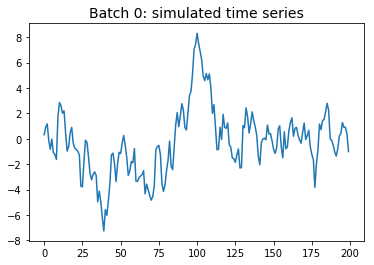

In [69]:
plt.plot(sim_data.detach().numpy()[0,:]);
plt.title('Batch 0: simulated time series', fontsize=14);

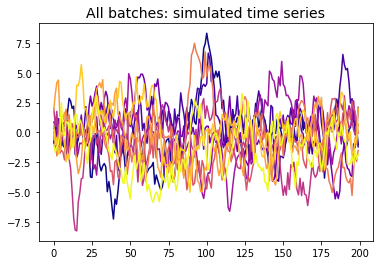

In [98]:
colors = plt.cm.plasma(np.linspace(0,1,sim_data.shape[0]))
for i in range(sim_data.shape[0]):
    plt.plot(sim_data.detach().numpy()[i,:], color = colors[i])
plt.title('All batches: simulated time series', fontsize=14);

### Train using IWAE
Now train our model using the IWAE algorithm.

First, we define `training_stats`, a class that logs important data throughout training.

In [100]:
# define training_stats
training_stats = lgssm.TrainingStats(
        initial_loc, initial_scale, true_transition_mult,
        transition_scale, true_emission_mult, emission_scale,
        num_timesteps, num_test_obs, test_inference_num_particles,
        saving_interval, logging_interval)

notice that this function defines again `self.initial`, `self.true_transition`,   `self.true_emission` which are used in a new `dataloader` over which we iterate to get `test_obs`, test data. 

In [104]:
print(vars(training_stats))

{'true_transition_mult': 0.9, 'true_emission_mult': 1, 'test_inference_num_particles': 1000, 'saving_interval': 10, 'logging_interval': 10, 'p_l2_history': [], 'q_l2_history': [], 'iteration_idx_history': [], 'initial': <models.lgssm.Initial object at 0xb1aa28240>, 'true_transition': Transition(), 'true_emission': Emission(), 'test_obs': [tensor([-1.0147,  1.3557,  1.0951,  0.8918, -0.6280, -0.1064, -0.0733, -1.1909,
        -1.2379,  1.5692]), tensor([-1.5206,  0.7023,  0.3896, -0.1859, -4.3255,  1.2330,  0.0818, -1.4467,
        -2.2514,  2.7581]), tensor([-2.4200,  1.1372,  1.1384,  0.1395, -3.7962, -1.4786,  0.4709, -0.0588,
        -1.7422,  2.5325]), tensor([-0.9363, -1.0774,  1.4535, -0.2989, -4.2210, -2.5452, -1.1069, -0.0240,
         0.3967,  1.6262]), tensor([-0.8442, -0.3071,  1.1456,  1.4831, -1.5654, -0.3972, -2.1903,  1.7653,
        -0.2266,  0.8622]), tensor([-1.3212, -0.0785,  0.4651,  0.3538, -1.1952, -1.7420, -1.5676,  2.4012,
        -1.5097,  1.1713]), tensor([-0.

In [111]:
print(len(training_stats.test_obs))
print(training_stats.test_obs[-1].shape) # torch size num_test_obs

200
torch.Size([10])


Now we send the model to train. in this function, we define the trainable classes for `initial`, `transition`, `emission` and `proposal` (the latter is first introduced here).

In [113]:
train.train(dataloader=dataloader,
                num_particles=num_particles,
                algorithm=algorithms[0], # iwae
                initial=lgssm.Initial(initial_loc, initial_scale),
                transition=lgssm.Transition(init_transition_mult,
                                            transition_scale),
                emission=lgssm.Emission(init_emission_mult,
                                        emission_scale),
                proposal=lgssm.Proposal(optimal_proposal_scale_0,
                                        optimal_proposal_scale_t),
                num_epochs=1,
                num_iterations_per_epoch=num_iterations,
                callback=training_stats)

Iteration 0: Loss = 5781325.5
Iteration 10: Loss = 5554836.0
Iteration 20: Loss = 5419377.5
Iteration 30: Loss = 5219234.5
Iteration 40: Loss = 3476086.0
Iteration 50: Loss = 6179873.0
Iteration 60: Loss = 4684240.0
Iteration 70: Loss = 4889363.5
Iteration 80: Loss = 4533052.0
Iteration 90: Loss = 5562197.0
Iteration 100: Loss = 4778797.5
Iteration 110: Loss = 4485346.5
Iteration 120: Loss = 4410183.0
Iteration 130: Loss = 4178349.5
Iteration 140: Loss = 4471520.0
Iteration 150: Loss = 4319789.0
Iteration 160: Loss = 3272881.0
Iteration 170: Loss = 3916316.75
Iteration 180: Loss = 3788285.25
Iteration 190: Loss = 3260384.0
Iteration 200: Loss = 3343532.5
Iteration 210: Loss = 2648745.5
Iteration 220: Loss = 2945928.5
Iteration 230: Loss = 2377706.75
Iteration 240: Loss = 2168336.5
Iteration 250: Loss = 1767520.25
Iteration 260: Loss = 1655879.125
Iteration 270: Loss = 1369285.625
Iteration 280: Loss = 1323685.75
Iteration 290: Loss = 1239687.75
Iteration 300: Loss = 1280191.375
Iterati

### Train using AESMC
Everything is the same except fot the resampling of the latent indices.

In [21]:
'''having the torch objects defined outside the function
hopefully means that they will be accessible in the workspace for inference'''
initial = lgssm.Initial(initial_loc, initial_scale)
transition = lgssm.Transition(init_transition_mult,
                                            transition_scale)
emission = lgssm.Emission(init_emission_mult,
                                        emission_scale)
proposal = lgssm.Proposal(optimal_proposal_scale_0,
                                        optimal_proposal_scale_t)

In [23]:
training_stats_aesmc = lgssm.TrainingStats(
    initial_loc, initial_scale, true_transition_mult,
    transition_scale, true_emission_mult, emission_scale,
    num_timesteps, num_test_obs, test_inference_num_particles,
    saving_interval, logging_interval)

In [24]:
train.train(dataloader=dataloader,
                num_particles=num_particles,
                algorithm=algorithms[1], # aesmc
                initial=initial,
                transition=transition,
                emission=emission,
                proposal=proposal,
                num_epochs=1,
                num_iterations_per_epoch=num_iterations,
                callback=training_stats_aesmc) # note the unique training_stats func

Iteration 0: Loss = 4776177.5
Iteration 10: Loss = 5075748.5
Iteration 20: Loss = 5077865.5
Iteration 30: Loss = 5023513.0
Iteration 40: Loss = 6110861.5
Iteration 50: Loss = 5227087.0
Iteration 60: Loss = 4512863.0
Iteration 70: Loss = 4824787.0
Iteration 80: Loss = 4877214.5
Iteration 90: Loss = 5080458.0
Iteration 100: Loss = 4533909.0
Iteration 110: Loss = 6098045.0
Iteration 120: Loss = 4548313.0
Iteration 130: Loss = 3690198.75
Iteration 140: Loss = 4140945.5
Iteration 150: Loss = 4165244.0
Iteration 160: Loss = 4894281.0
Iteration 170: Loss = 4490115.0
Iteration 180: Loss = 3885428.5
Iteration 190: Loss = 4590473.0
Iteration 200: Loss = 5155935.0
Iteration 210: Loss = 4420293.5
Iteration 220: Loss = 3751668.75
Iteration 230: Loss = 4242773.0
Iteration 240: Loss = 3670115.5
Iteration 250: Loss = 3736207.25
Iteration 260: Loss = 3595723.25
Iteration 270: Loss = 3669318.75
Iteration 280: Loss = 3153833.5
Iteration 290: Loss = 3399020.75
Iteration 300: Loss = 2699820.75
Iteration 31

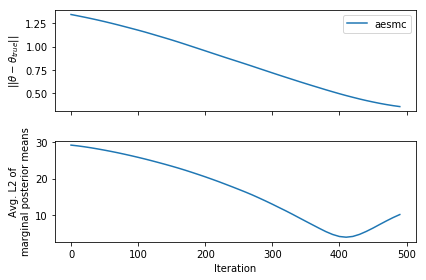

In [25]:
fig, axs = plt.subplots(2, 1, sharex=True)
# axs[0].plot(training_stats.iteration_idx_history,
#                 training_stats.p_l2_history,
#                 label=algorithms[0])
axs[0].plot(training_stats_aesmc.iteration_idx_history,
                training_stats_aesmc.p_l2_history,
                label=algorithms[1])
# axs[1].plot(training_stats.iteration_idx_history,
#             training_stats.q_l2_history,
#             label=algorithms[0])
axs[1].plot(training_stats_aesmc.iteration_idx_history,
            training_stats_aesmc.q_l2_history,
            label=algorithms[1])
axs[0].set_ylabel('$||\\theta - \\theta_{true}||$')
axs[1].set_ylabel('Avg. L2 of\nmarginal posterior means')
axs[-1].set_xlabel('Iteration')
axs[0].legend()
fig.tight_layout()

so with 1000 particles for SMC, training is much slower. looks even better after training with 200 particles. in both cases - testing is with 1000 particles. losses for learned parameters are decresing as they should. But the lower plot shows a weird trend between iteration 200 and 300.

In [29]:
print(vars(proposal))

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend object at 0xb2612fbe0>, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_backward_hooks': OrderedDict(), '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': OrderedDict([('lin_0', Linear(in_features=1, out_features=1, bias=True)), ('lin_t', Linear(in_features=2, out_features=1, bias=True))]), 'training': True, 'scale_0': 0.009999500037497706, 'scale_t': 0.009999500037497706}


In [105]:
# create a time series of observations for test
observations = (next(iter(dataloader)))
print(len(observations))

200


infer latent variables on a test data, using the trained `initial`, `transition`, `emission` and `proposal` instances.

In [106]:
inference_result = inference.infer(
            inference_algorithm='smc',
            observations=observations, # created above when we played with creating data
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=1000
        )

In [107]:
len(inference_result) # we have many entries from log_weight to latents, etc. 

7

In [108]:
# ToDo: consider wrapping in a function e.g., summarize_posterior(latents, their weights)
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(stats.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(stats.empirical_variance(
        latent, inference_result['log_weight']
    ))

In [114]:
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in observations], dim=1)
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=1)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=1)

So we organized those lists into tensors (which we later detach and send to numpy). each tensor had dim `[batch_size, num_timesteps]`. In this particular case, the 1-D latents are almost directly transformed into the observations:

$$
g(\vec{x}_t|\vec{z}_t) = \mathcal{N}(1*\vec{z}_{t}, 0.01) \quad \text{[emiss.]}
$$
There's not much variance in the emission and therefore we infer the latents with almost 0 variance. 

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


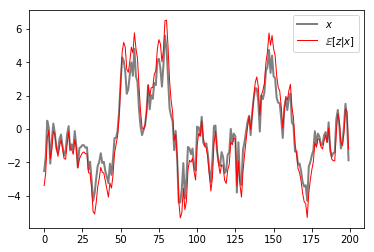

In [144]:
ind_in_batch = 5 # could be between 0 and batch_size-1
plt.plot(sim_data[ind_in_batch,:].detach().numpy(), 
         label = '$x$', color = 'gray', linewidth=2)
plt.plot(smooth_data[ind_in_batch,:].detach().numpy(), 
         label = '$\mathbb{E}[z|x]$', color = 'red', linewidth=1)
plt.fill_between(
            np.arange(num_timesteps),
            smooth_mean[ind_in_batch,:].detach().numpy() -
            np.sqrt(smooth_var[ind_in_batch,:].detach().numpy()),
            smooth_mean[ind_in_batch,:].detach().numpy() +
            np.sqrt(smooth_var[ind_in_batch,:].detach().numpy()),
            alpha=0.8,
            color='gray'
        )
plt.legend();

In [122]:
smooth_var[ind_in_batch,:].detach().numpy().shape

(200,)

In [51]:
smc_smoothed_state_means[-1].detach().numpy()

array(-0.51331913, dtype=float32)

In [72]:
print('let\'s understand the output of our inference algorithm:')
print('length of inference_result[\'latents\'] list:')
print(len(inference_result['latents']))
print('size of inference_result[\'latents\'][-1] tensor:')
print(inference_result['latents'][-1].shape)
print('that is, ([batch_size, num_particles])')
print('=============')
#print('length of inference_result[\'log_weights\'] list:')
#print(len(inference_result['log_weights']))

let's understand the output of our inference algorithm:
length of inference_result['latents'] list:
200
size of inference_result['latents'][-1] tensor:
torch.Size([10, 1000])
that is, ([batch_size, num_particles])
length of inference_result['log_weights'] list:


TypeError: object of type 'NoneType' has no len()

In [75]:
inference_result['log_weight']==inference_result['log_weights'][-1]

TypeError: 'NoneType' object is not subscriptable

In [78]:
print(inference_result['log_weights'])

None


In [81]:
res = stats.empirical_mean(
        latent, inference_result['log_weight']
    )
print(res.shape)

torch.Size([10])


tensor([-5.1332e-01,  2.5006e-01, -3.6658e+00, -1.3303e+00,  1.6716e-01,
         3.0830e+00, -3.1313e+00, -5.3026e-01, -2.5805e-03,  3.3834e+00],
       grad_fn=<AddBackward0>)